# Supplementary Code: Image-Based & Machine Learning-Guided Multiplexed Serology Test for SARS-CoV-2 

*Vilja Pietiäinen, Minttu Polso, Ede Migh, Christian Guckelsberger,  Maria Harmati, Akos Diosdi, Laura Turunen, Antti Hassinen, Swapnil Potdar,  Annika Koponen, Edina Gyukity Sebestyen, Ferenc Kovacs, Andras Kriston, Reka Hollandi, Katalin Burian, Gabriella Terhes, Adam Visnyovszky, Eszter Fodor, Zsombor Lacza, Anu Kantele, Pekka Kolehmainen, Laura Kakkola, Tomas Strandin, Lev Levanov, Olli Kallioniemi, Lajos Kemeny, Ilkka Julkunen, Olli Vapalahti, Krisztina Buzas, Lassi Paavolainen, Peter Horvath and Jussi Hepojoki*

## Code Overview

This Python Jupyter Notebook captures most of the analysis pipeline as described in the main article and supplementary text. It comprises analysis steps 6 and 7 to generate per-cell and per-well predictions of antibody positivity on automated high-content fluorescence microscopy images, obtained from high-throughput serological tests. Moreover, it contains evaluation scripts for comparing our predictions against ELISA and visual ground truth data. 

The analysis is exemplified on SARS-CoV-2 antigens N, Spike (S), Membrane (M) and RBD (R), as well as antibodies IgG, IgA and IgM. The notebook allows to *reproduce all results* from the article and supplementary.

The code is separated into 4 parts:

1. **Cross-Validation for Hyperparameter Tuning**: Yields optimal classifier hyperparameters that maximises a specificity x sensitivity trade-off on 5-class per-cell predictions. A train-validation split is applied across plates to warrant good prediction performance on previously unseen plates.
2. **Model Training**: Uses the cross-validation output or pre-determined hyperparameters to re-train the classifier over the entire training data set.
3. **Predictions**: Generates per-cell predictions and per-well positive ratio estimates with this classifier on a dataset that is distinct from the training data.
4. **Evaluation**: Compares the predicted per-well positivity ratios against visual ground truth data from expert virologists, and ELISA on the same samples.

The data used is the result of analysis step 5, i.e. image-pre-processing, nucleus segmentation and feature extraction. It has been anonymized. 

## Imports
Libraries used in multiple parts of this notebook - do not modify.

In [1]:
import os
import csv
import random
import pandas as pd
from pathlib import Path
from IPython.display import display, HTML
from IPython.lib import kernel

import construct_data, training, predict, evaluate, plotting

## Settings

Set the variables below to run this notebook for any combination of antibody, protein, classifier and normalisation scheme. 

Small amounts of randomness in the classifier training can yield different optimal hyperparameters in the cross-validation. To ensure successful reproduction of the results as documented in the article, set the "use_original_hyperparameters" flag to True.

**Note**: Once a setting has been changed, all cells below must be re-run to ensure consistency of the results.

In [2]:
# Notebook settings
%load_ext autoreload
%autoreload 2

# Check id for output location
connection_file_path = kernel.get_connection_file()
connection_file = os.path.basename(connection_file_path)
kernel_id = connection_file.split('-', 1)[1].split('.')[0]

# Fixed settings
from fixed_settings import path_data_raw, path_data_auxiliary, path_output, file_classes, file_controls, file_metadata, file_original_hyperparameters, file_elisa, file_visual_gt, dilution_antibody
path_tmp = path_output / kernel_id
if not os.path.exists(path_tmp):
    os.mkdir(path_tmp)

# Virus protein
protein = "S" 
assert protein in ["N", "S", "R", "M"], "Incorrect protein setting. Please choose from the available options."

# Antibody
antibody = "IgG"
assert antibody in ["IgM","IgG","IgA"], "Incorrect antibody setting. Please choose from the available options."

# Normalisation method
normalisation_type = "NegOnly"
assert normalisation_type in ["PosNeg","NegOnly","PosNegBal"], "Incorrect antibody setting. Please choose from the available options."

# Classifier (ANN, SVM, RF)
classifier_type = "ANN"
assert classifier_type in ["ANN","SVM","RF"], "Incorrect classifier setting. Please choose from the available options."

# Original classifier hyperparameters flag 
# True: use the hyperparameters documented in the article. 
# False: use hyperparameters determiend in the cross-validation in this notebook.
use_original_hyperparameters = True
assert use_original_hyperparameters in [True, False], "Incorrect setting for use_original_hyperparameters flag. Please use a Boolean value."

## Load Global Data

Load data used throughout the different parts of this notebook: a mapping from class indices to human-readable labels, a list of control well identifiers and metadata with per-well/plate information on a well's content, dilution and whether it has successfully transferred, the latter being determined automatically.

In [3]:
# Classes in the data and label code
classes = dict()
reader = csv.reader(open(path_data_auxiliary/file_classes, 'r'))
for k, v in reader:
    classes[int(k)] = v
print("Classes:\n{}\n".format(classes))

# Controls: well name, type (positive/negative), dilution
df_controls = pd.read_csv(path_data_auxiliary/file_controls)
print("Controls:")
display(HTML(df_controls.to_html(index=False)))

# Metadata
df_meta = pd.read_csv(path_data_auxiliary/file_metadata)
df_meta = df_meta[['Destination Plate Barcode', 'Dest Well', 'Sample Name', 'Sample', 'Content', 'Dilution', 'Transferred']]
df_meta.rename(columns={'Dest Well':'well'}, inplace=True)
print("Metadata:")
display(HTML(df_meta.head(10).to_html(index=False)))

Classes:
{1: 'positive', 2: 'negative', 3: 'atypical', 4: 'small bright', 5: 'trash'}

Controls:


Content,Type,Dilution
POS1_25,positive,25
POS2_25,positive,25
POS1_100,positive,100
POS2_100,positive,100
NEG1_25,negative,25
NEG2_25,negative,25
NEG3_25,negative,25
NEG1_100,negative,100
NEG2_100,negative,100
NEG3_100,negative,100


Metadata:


Destination Plate Barcode,well,Sample Name,Sample,Content,Dilution,Transferred
M_1_1,A1,EMPTY,0,EMPTY,0,True
M_1_1,B1,S2020_003,1,Sample1_25,25,True
M_1_1,C1,S2020_003,1,Sample1_100,100,True
M_1_1,D1,S2020_004,1,Sample2_25,25,True
M_1_1,E1,S2020_004,1,Sample2_100,100,True
M_1_1,F1,S2020_005,1,Sample3_25,25,True
M_1_1,G1,S2020_005,1,Sample3_100,100,True
M_1_1,H1,S2020_007,1,Sample4_25,25,True
M_1_1,I1,S2020_007,1,Sample4_100,100,True
M_1_1,J1,NEG3,0,Secondaries only,1,True


## Part 1: Cross-Validation for Hyperparameter Tuning
We perform a four-fold leave-one-out cross-validation on the level of plates to identify optimal classifier hyperparameters that yield good predictions also on previously unseen plates.


### Create cross-validation data
Each of the four cross-validation folds constructed here comprises training data of three plates, and used the remaining plate as validation data.

In [4]:
construct_data.construct_data_cross_validation(path_data_raw/"data_{}_cv/".format(protein), path_tmp/"data_{}_cv/".format(protein), classes, df_controls, df_meta, normalisation_type, antibody, dilution_antibody)

Reading plate S_1_5

Labelled samples for antibody IgG for dilution 100:
positive: 245
negative: 524
atypical: 463
small bright: 122
trash: 127

Normalising for dilution 100
Only 4 of 6 positive control wells were transferred -- still sufficient. Continuing normalisation.
Normalisation based on negative controls only

Reading plate S_1_3

Labelled samples for antibody IgG for dilution 100:
positive: 178
negative: 366
atypical: 329
small bright: 105
trash: 102

Normalising for dilution 100
Only 2 of 6 positive control wells were transferred -- still sufficient. Continuing normalisation.
Only 3 of 10 negative control wells were transferred -- still sufficient. Continuing normalisation.
Normalisation based on negative controls only

Reading plate S_1_1

Labelled samples for antibody IgG for dilution 100:
positive: 373
negative: 836
atypical: 166
small bright: 160
trash: 140

Normalising for dilution 100
Only 7 of 10 negative control wells were transferred -- still sufficient. Continuing n

In [5]:
# Load and print some random lines from cross-validation data
example_file = [fn for fn in os.listdir(path_tmp/"data_{}_cv/".format(protein)) if (fn.endswith("hdf5") and (antibody in fn))][0]
print("Example file: {}\n".format(example_file))

example_file_path = Path(path_tmp/"data_{}_cv/".format(protein))/example_file
df_X_train = pd.read_hdf(example_file_path, key='X_train')
df_y_train = pd.read_hdf(example_file_path, key='y_train')
df_y_train["Label (human-readable)"] = df_y_train.replace({"Label":classes})
rnd_ixs = random.sample(range(0, df_X_train.shape[0]), 5)

print("Features:")
display(HTML(df_X_train.take(rnd_ixs).to_html(index=False)))

print("Labels:")
display(HTML(df_y_train.take(rnd_ixs).to_html(index=False)))


Example file: leave_S_1_1_out_train_on_S_1_5_and_S_1_3_and_S_2_4_ab_IgG_and_DAPI_dil_100.hdf5

Features:


CELL.AREA,CELL.ELLIPSE-ECCENTRICITY,CELL.ELLIPSE-MAJOR.AXIS.LENGTH,CELL.ELLIPSE-MINOR.AXIS.LENGTH,CELL.ENCLOSING.CIRCLE.RADIUS,CELL.EXTENT,CELL.FORM.FACTOR,CELL.HARALICK.TEXTURE-1.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-1.DAPI.0.3,CELL.HARALICK.TEXTURE-10.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-10.DAPI.0.3,CELL.HARALICK.TEXTURE-11.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-11.DAPI.0.3,CELL.HARALICK.TEXTURE-12.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-12.DAPI.0.3,CELL.HARALICK.TEXTURE-2.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-2.DAPI.0.3,CELL.HARALICK.TEXTURE-3.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-3.DAPI.0.3,CELL.HARALICK.TEXTURE-4.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-4.DAPI.0.3,CELL.HARALICK.TEXTURE-5.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-5.DAPI.0.3,CELL.HARALICK.TEXTURE-6.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-6.DAPI.0.3,CELL.HARALICK.TEXTURE-7.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-7.DAPI.0.3,CELL.HARALICK.TEXTURE-8.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-8.DAPI.0.3,CELL.HARALICK.TEXTURE-9.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-9.DAPI.0.3,CELL.INTEGRATED.INTENSITY.Alexa.IgG,CELL.INTEGRATED.INTENSITY.DAPI,CELL.INTENSITY-MAX.Alexa.IgG,CELL.INTENSITY-MAX.DAPI,CELL.INTENSITY-MEAN.Alexa.IgG,CELL.INTENSITY-MEAN.DAPI,CELL.INTENSITY-MEDIAN.Alexa.IgG,CELL.INTENSITY-MEDIAN.DAPI,CELL.INTENSITY-MIN.Alexa.IgG,CELL.INTENSITY-MIN.DAPI,CELL.INTENSITY-STDDEV.Alexa.IgG,CELL.INTENSITY-STDDEV.DAPI,CELL.NUMBER.OF.COMPONENTS,CELL.PERIMETER,CELL.REAL.DIAMETER,CELL.REAL.PERIMETER,CELL.SOLIDITY,CELL.VOLUMETRY,DONUT.AREA,DONUT.ELLIPSE-ECCENTRICITY,DONUT.ELLIPSE-MAJOR.AXIS.LENGTH,DONUT.ELLIPSE-MINOR.AXIS.LENGTH,DONUT.ENCLOSING.CIRCLE.RADIUS,DONUT.EXTENT,DONUT.FORM.FACTOR,DONUT.HARALICK.TEXTURE-1.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-1.DAPI.0.3,DONUT.HARALICK.TEXTURE-10.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-10.DAPI.0.3,DONUT.HARALICK.TEXTURE-11.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-11.DAPI.0.3,DONUT.HARALICK.TEXTURE-12.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-12.DAPI.0.3,DONUT.HARALICK.TEXTURE-2.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-2.DAPI.0.3,DONUT.HARALICK.TEXTURE-3.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-3.DAPI.0.3,DONUT.HARALICK.TEXTURE-4.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-4.DAPI.0.3,DONUT.HARALICK.TEXTURE-5.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-5.DAPI.0.3,DONUT.HARALICK.TEXTURE-6.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-6.DAPI.0.3,DONUT.HARALICK.TEXTURE-7.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-7.DAPI.0.3,DONUT.HARALICK.TEXTURE-8.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-8.DAPI.0.3,DONUT.HARALICK.TEXTURE-9.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-9.DAPI.0.3,DONUT.INTEGRATED.INTENSITY.Alexa.IgG,DONUT.INTEGRATED.INTENSITY.DAPI,DONUT.INTENSITY-MAX.Alexa.IgG,DONUT.INTENSITY-MAX.DAPI,DONUT.INTENSITY-MEAN.Alexa.IgG,DONUT.INTENSITY-MEAN.DAPI,DONUT.INTENSITY-MEDIAN.Alexa.IgG,DONUT.INTENSITY-MEDIAN.DAPI,DONUT.INTENSITY-MIN.Alexa.IgG,DONUT.INTENSITY-MIN.DAPI,DONUT.INTENSITY-STDDEV.Alexa.IgG,DONUT.INTENSITY-STDDEV.DAPI,DONUT.NUMBER.OF.COMPONENTS,DONUT.PERIMETER,DONUT.REAL.DIAMETER,DONUT.REAL.PERIMETER,DONUT.SOLIDITY,DONUT.VOLUMETRY,NUCLEUS.AREA,NUCLEUS.ELLIPSE-ECCENTRICITY,NUCLEUS.ELLIPSE-MAJOR.AXIS.LENGTH,NUCLEUS.ELLIPSE-MINOR.AXIS.LENGTH,NUCLEUS.ENCLOSING.CIRCLE.RADIUS,NUCLEUS.EXTENT,NUCLEUS.FORM.FACTOR,NUCLEUS.HARALICK.TEXTURE-1.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-1.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-10.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-10.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-11.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-11.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-12.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-12.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-2.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-2.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-3.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-3.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-4.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-4.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-5.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-5.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-6.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-6.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-7.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-7.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-8.Alexa.IgG.0.3,NUCLEUS.HARALICK.TE

Labels:


Label,Label (human-readable)
3,atypical
2,negative
2,negative
1,positive
2,negative


### Perform cross-validation 

Each score (sensitivity, specificity, accuracy) is recorded twice:
- default: Calculated over all classes via "micro averaging", taking into account the total true positives, false negatives and false positives.
- "pos"-suffix: Calculated over the "positive" class only to determine how good the model is at disciminating "positive" cells from all other classes.

**Note**: Running this code can take up to 30 minutes (fastest for SVM, slowest for ANN). To run this demonstration within a reasonable time, the parameter grid for all classifier types has been downsized. To warrant reproduction, it still includes the hyperparameter configuration identified as optimal in the article.

In [6]:
# Run cross-validation and print scores for different hyperparameter configurations
hp_best_cv, cm = training.train_cv(classifier_type, path_tmp/"data_{}_cv/".format(protein), antibody, classes)

Loading cross-validation data features and labels from data_out/cb182265-a18c-436b-9303-7e224b120fee/data_S_cv

Training and validating ANN on fold leave_S_1_1_out_train_on_S_1_5_and_S_1_3_and_S_2_4_ab_IgG_and_DAPI_dil_100.hdf5
Train/validation split: 3531 / 1675
Tuning hyper-parameters for specsens
Best parameter set for specsens:
{'hidden_layer_sizes': 32, 'alpha': 0.05}

Scores on validation set:
specificity:
0.986 for {'alpha': 0.05, 'hidden_layer_sizes': 32}
0.986 for {'alpha': 0.1, 'hidden_layer_sizes': 32}
0.985 for {'alpha': 0.1, 'hidden_layer_sizes': (32, 32)}
0.985 for {'alpha': 0.001, 'hidden_layer_sizes': 32}
0.985 for {'alpha': 0.05, 'hidden_layer_sizes': (32, 32)}
0.984 for {'alpha': 1.0, 'hidden_layer_sizes': 64}
0.984 for {'alpha': 1.0, 'hidden_layer_sizes': (128, 64)}
0.984 for {'alpha': 1.0, 'hidden_layer_sizes': 32}
0.984 for {'alpha': 0.1, 'hidden_layer_sizes': 64}
0.984 for {'alpha': 0.05, 'hidden_layer_sizes': 64}
0.984 for {'alpha': 1.0, 'hidden_layer_sizes': (32

Best parameter set for specsens:
{'hidden_layer_sizes': 64, 'alpha': 0.1}

Scores on validation set:
specificity:
0.973 for {'alpha': 0.1, 'hidden_layer_sizes': 64}
0.973 for {'alpha': 0.1, 'hidden_layer_sizes': 32}
0.973 for {'alpha': 0.05, 'hidden_layer_sizes': 64}
0.973 for {'alpha': 0.05, 'hidden_layer_sizes': 32}
0.973 for {'alpha': 0.001, 'hidden_layer_sizes': 32}
0.973 for {'alpha': 0.1, 'hidden_layer_sizes': (128, 64)}
0.972 for {'alpha': 0.1, 'hidden_layer_sizes': (32, 32)}
0.972 for {'alpha': 0.001, 'hidden_layer_sizes': 64}
0.972 for {'alpha': 1.0, 'hidden_layer_sizes': 32}
0.972 for {'alpha': 0.05, 'hidden_layer_sizes': (32, 32)}
0.971 for {'alpha': 1.0, 'hidden_layer_sizes': 64}
0.971 for {'alpha': 0.05, 'hidden_layer_sizes': (128, 64)}
0.970 for {'alpha': 1.0, 'hidden_layer_sizes': (32, 32)}
0.970 for {'alpha': 0.001, 'hidden_layer_sizes': (32, 32)}
0.968 for {'alpha': 1.0, 'hidden_layer_sizes': (128, 64)}
0.968 for {'alpha': 0.001, 'hidden_layer_sizes': (128, 64)}
specif

Confusion matrix:


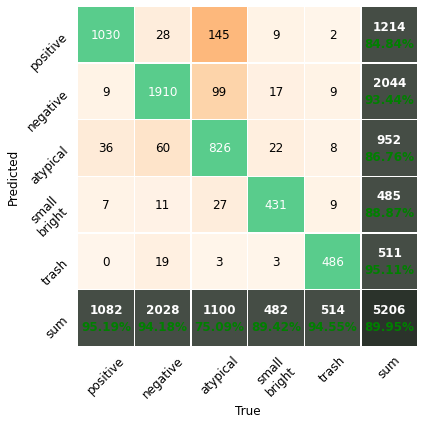

In [7]:
# Visualise confusion matrix for best hyperparameter configuration
print("Confusion matrix:")
plotting.plot_confusion_matrix(cm, classes)

## Part 2: Model Training
Here, the chosen classifier is re-trained over the entire training data set using a set of previously identified, optimal hyperparameters.

### Create Training Data
In contrast to the cross-validation procedure, we do not perform a split into train/validation sets; all data is used for training.

In [8]:
construct_data.construct_training_data(path_data_raw/"data_{}_cv/".format(protein),  path_tmp/"data_{}_training/".format(protein), classes, df_controls, df_meta, normalisation_type, antibody, dilution_antibody)

Reading plate S_1_5

Labelled samples for antibody IgG for dilution 100:
positive: 245
negative: 524
atypical: 463
small bright: 122
trash: 127

Normalising for dilution 100
Only 4 of 6 positive control wells were transferred -- still sufficient. Continuing normalisation.
Normalisation based on negative controls only

Reading plate S_1_3

Labelled samples for antibody IgG for dilution 100:
positive: 178
negative: 366
atypical: 329
small bright: 105
trash: 102

Normalising for dilution 100
Only 2 of 6 positive control wells were transferred -- still sufficient. Continuing normalisation.
Only 3 of 10 negative control wells were transferred -- still sufficient. Continuing normalisation.
Normalisation based on negative controls only

Reading plate S_1_1

Labelled samples for antibody IgG for dilution 100:
positive: 373
negative: 836
atypical: 166
small bright: 160
trash: 140

Normalising for dilution 100
Only 7 of 10 negative control wells were transferred -- still sufficient. Continuing n

In [9]:
# Load training data
filename = [fn for fn in os.listdir(path_tmp/"data_{}_training/".format(protein)) if (fn.endswith("hdf5") and (antibody in fn))][0]

file_path = Path(path_tmp/"data_{}_training/".format(protein))/filename
df_X = pd.read_hdf(file_path, key='X')
df_y = pd.read_hdf(file_path, key='y')
df_y["Label (human-readable)"] = df_y.replace({"Label":classes})
rnd_ixs = random.sample(range(0, df_X.shape[0]), 5)

# Print amount of data
print("The training data contains {} samples.\n".format(df_X.shape[0]))
    
# Print some random lines from training data
print("Features:")
display(HTML(df_X.take(rnd_ixs).to_html(index=False)))

print("Labels:")
display(HTML(df_y.take(rnd_ixs).to_html(index=False)))


The training data contains 5206 samples.

Features:


CELL.AREA,CELL.ELLIPSE-ECCENTRICITY,CELL.ELLIPSE-MAJOR.AXIS.LENGTH,CELL.ELLIPSE-MINOR.AXIS.LENGTH,CELL.ENCLOSING.CIRCLE.RADIUS,CELL.EXTENT,CELL.FORM.FACTOR,CELL.HARALICK.TEXTURE-1.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-1.DAPI.0.3,CELL.HARALICK.TEXTURE-10.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-10.DAPI.0.3,CELL.HARALICK.TEXTURE-11.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-11.DAPI.0.3,CELL.HARALICK.TEXTURE-12.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-12.DAPI.0.3,CELL.HARALICK.TEXTURE-2.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-2.DAPI.0.3,CELL.HARALICK.TEXTURE-3.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-3.DAPI.0.3,CELL.HARALICK.TEXTURE-4.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-4.DAPI.0.3,CELL.HARALICK.TEXTURE-5.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-5.DAPI.0.3,CELL.HARALICK.TEXTURE-6.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-6.DAPI.0.3,CELL.HARALICK.TEXTURE-7.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-7.DAPI.0.3,CELL.HARALICK.TEXTURE-8.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-8.DAPI.0.3,CELL.HARALICK.TEXTURE-9.Alexa.IgG.0.3,CELL.HARALICK.TEXTURE-9.DAPI.0.3,CELL.INTEGRATED.INTENSITY.Alexa.IgG,CELL.INTEGRATED.INTENSITY.DAPI,CELL.INTENSITY-MAX.Alexa.IgG,CELL.INTENSITY-MAX.DAPI,CELL.INTENSITY-MEAN.Alexa.IgG,CELL.INTENSITY-MEAN.DAPI,CELL.INTENSITY-MEDIAN.Alexa.IgG,CELL.INTENSITY-MEDIAN.DAPI,CELL.INTENSITY-MIN.Alexa.IgG,CELL.INTENSITY-MIN.DAPI,CELL.INTENSITY-STDDEV.Alexa.IgG,CELL.INTENSITY-STDDEV.DAPI,CELL.NUMBER.OF.COMPONENTS,CELL.PERIMETER,CELL.REAL.DIAMETER,CELL.REAL.PERIMETER,CELL.SOLIDITY,CELL.VOLUMETRY,DONUT.AREA,DONUT.ELLIPSE-ECCENTRICITY,DONUT.ELLIPSE-MAJOR.AXIS.LENGTH,DONUT.ELLIPSE-MINOR.AXIS.LENGTH,DONUT.ENCLOSING.CIRCLE.RADIUS,DONUT.EXTENT,DONUT.FORM.FACTOR,DONUT.HARALICK.TEXTURE-1.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-1.DAPI.0.3,DONUT.HARALICK.TEXTURE-10.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-10.DAPI.0.3,DONUT.HARALICK.TEXTURE-11.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-11.DAPI.0.3,DONUT.HARALICK.TEXTURE-12.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-12.DAPI.0.3,DONUT.HARALICK.TEXTURE-2.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-2.DAPI.0.3,DONUT.HARALICK.TEXTURE-3.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-3.DAPI.0.3,DONUT.HARALICK.TEXTURE-4.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-4.DAPI.0.3,DONUT.HARALICK.TEXTURE-5.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-5.DAPI.0.3,DONUT.HARALICK.TEXTURE-6.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-6.DAPI.0.3,DONUT.HARALICK.TEXTURE-7.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-7.DAPI.0.3,DONUT.HARALICK.TEXTURE-8.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-8.DAPI.0.3,DONUT.HARALICK.TEXTURE-9.Alexa.IgG.0.3,DONUT.HARALICK.TEXTURE-9.DAPI.0.3,DONUT.INTEGRATED.INTENSITY.Alexa.IgG,DONUT.INTEGRATED.INTENSITY.DAPI,DONUT.INTENSITY-MAX.Alexa.IgG,DONUT.INTENSITY-MAX.DAPI,DONUT.INTENSITY-MEAN.Alexa.IgG,DONUT.INTENSITY-MEAN.DAPI,DONUT.INTENSITY-MEDIAN.Alexa.IgG,DONUT.INTENSITY-MEDIAN.DAPI,DONUT.INTENSITY-MIN.Alexa.IgG,DONUT.INTENSITY-MIN.DAPI,DONUT.INTENSITY-STDDEV.Alexa.IgG,DONUT.INTENSITY-STDDEV.DAPI,DONUT.NUMBER.OF.COMPONENTS,DONUT.PERIMETER,DONUT.REAL.DIAMETER,DONUT.REAL.PERIMETER,DONUT.SOLIDITY,DONUT.VOLUMETRY,NUCLEUS.AREA,NUCLEUS.ELLIPSE-ECCENTRICITY,NUCLEUS.ELLIPSE-MAJOR.AXIS.LENGTH,NUCLEUS.ELLIPSE-MINOR.AXIS.LENGTH,NUCLEUS.ENCLOSING.CIRCLE.RADIUS,NUCLEUS.EXTENT,NUCLEUS.FORM.FACTOR,NUCLEUS.HARALICK.TEXTURE-1.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-1.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-10.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-10.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-11.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-11.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-12.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-12.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-2.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-2.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-3.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-3.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-4.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-4.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-5.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-5.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-6.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-6.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-7.Alexa.IgG.0.3,NUCLEUS.HARALICK.TEXTURE-7.DAPI.0.3,NUCLEUS.HARALICK.TEXTURE-8.Alexa.IgG.0.3,NUCLEUS.HARALICK.TE

Labels:


Label,Label (human-readable)
5,trash
2,negative
5,trash
5,trash
2,negative


### Train Model
If "use_original_hyperparameters" has been set to False, this script will use the optimal hyperparameters as identified in the previous cross-validation (part 2). If set to True, optimal hyperparameters as identified in the article will be used. We recommend using the latter setting to reproduce our original findings.

In [10]:
# Depending on "use_original_hyperparameters" flag, use the optimal hyperparameters as determined in the article or in the previous cross-validation
df_hp_best_original = pd.read_csv(path_data_auxiliary/file_original_hyperparameters, delimiter=";")
hp_best_original = eval(df_hp_best_original[(df_hp_best_original.protein == protein) & (df_hp_best_original.antibody == antibody)][classifier_type].iloc[0])
hp_best = hp_best_original if use_original_hyperparameters else hp_best_cv 
assert hp_best is not None, "Optimal hyperparameters for model training missing. Make sure that either the cross-validation has been rund beforehand, or that 'use_original_hyperparameters' is set True."

# Train model
classifier = training.train(classifier_type, path_tmp/"data_{}_training/".format(protein), antibody, hp_best)

Loading data features and labels
Training classifier ANN with hyperparameters {'activation': 'logistic', 'max_iter': 1000000, 'learning_rate_init': 0.0001, 'alpha': 0.1, 'hidden_layer_sizes': (32, 32)}
Training completed.


## Part 3: Predictions 
The trained model is applied to predict the class of each segmented cell in a specific sample well, over all wells in a plate with the antibody-specific dilution. Our per-well antibody positivity predictions correspond to the number of positively classified cells divided by the total segmented cell count in the well.

**Note**: Producing the predictions can take up to 5 minutes per plate, i.e. 20 minutes in total.


In [11]:
predict.predict(classifier, classifier_type, path_data_raw/"data_{}_test/".format(protein), path_tmp/"ratios_{}/".format(protein), antibody, classes, df_controls, df_meta, normalisation_type, dilution_antibody)

Loading feature data for plate data_raw/data_S_test/S_3_2.hdf5

Normalising data for dilution 100
Normalisation based on negative controls only

Calculating predictions for antibody IgG and dilution 100
Calculating per-cell predictions
Calculating per-well ratios

Exporting per-well prediction results to data_out/cb182265-a18c-436b-9303-7e224b120fee/ratios_S/ratios_per_well_plate_S_3_2_ab_IgG.csv

Loading feature data for plate data_raw/data_S_test/S_3_1.hdf5

Normalising data for dilution 100
Normalisation based on negative controls only

Calculating predictions for antibody IgG and dilution 100
Calculating per-cell predictions
Calculating per-well ratios

Exporting per-well prediction results to data_out/cb182265-a18c-436b-9303-7e224b120fee/ratios_S/ratios_per_well_plate_S_3_1_ab_IgG.csv

Loading feature data for plate data_raw/data_S_test/S_3_4.hdf5

Normalising data for dilution 100
Normalisation based on negative controls only

Calculating predictions for antibody IgG and dilution

In [12]:
# Print per-well predictions for 1 pos/neg control
example_file = [fn for fn in os.listdir(path_tmp/"ratios_{}/".format(protein)) if (fn.endswith(".csv") and (antibody in fn))][0]
print("Example file: {}\n".format(example_file))
df_ratios = pd.read_csv(Path(path_tmp)/"ratios_{}/".format(protein)/example_file)

ctrl_pos = df_controls[(df_controls.Type=="positive") & (df_controls.Dilution==dilution_antibody[antibody])].Content.iloc[0]
ctrl_neg = df_controls[(df_controls.Type=="negative") & (df_controls.Dilution==dilution_antibody[antibody])].Content.iloc[0]

df_ratios_ctrl_pos = df_ratios[df_ratios.Content == ctrl_pos]
df_ratios_ctrl_neg = df_ratios[df_ratios.Content == ctrl_neg]

print("Per-well {} positivity predictions on positive controls:".format(antibody))
display(HTML(df_ratios_ctrl_pos.to_html(index=False)))

print("Per-well {} positivity predictions on negative controls:".format(antibody))
display(HTML(df_ratios_ctrl_neg.to_html(index=False)))


Example file: ratios_per_well_plate_S_3_3_ab_IgG.csv

Per-well IgG positivity predictions on positive controls:


well,Cell Count,Ratio positive IgG,Ratio negative IgG,Ratio atypical IgG,Ratio small bright IgG,Ratio trash IgG,Destination Plate Barcode,Sample Name,Sample,Content,Dilution,Transferred
A3,4344.0,0.189917,0.298573,0.317449,0.089779,0.104282,S_3_3,POS1,0,POS1_100,100,True
F9,7122.0,0.165965,0.421792,0.273940,0.060095,0.078208,S_3_3,POS1,0,POS1_100,100,True
J15,6845.0,0.152520,0.482104,0.244412,0.054785,0.066180,S_3_3,POS1,0,POS1_100,100,True
E24,7736.0,0.124612,0.523914,0.199974,0.054421,0.097079,S_3_3,POS1,0,POS1_100,100,True


Per-well IgG positivity predictions on negative controls:


well,Cell Count,Ratio positive IgG,Ratio negative IgG,Ratio atypical IgG,Ratio small bright IgG,Ratio trash IgG,Destination Plate Barcode,Sample Name,Sample,Content,Dilution,Transferred
B6,6777.0,0.000148,0.796813,0.048694,0.046186,0.108160,S_3_3,NEG1,0,NEG1_100,100,True
L12,6794.0,0.000147,0.787754,0.064174,0.037092,0.110833,S_3_3,NEG1,0,NEG1_100,100,True
B16,6888.0,0.000000,0.886905,0.013357,0.023519,0.076220,S_3_3,NEG1,0,NEG1_100,100,True
L23,7350.0,0.000000,0.897415,0.001224,0.020000,0.081361,S_3_3,NEG1,0,NEG1_100,100,True


## Part 4: Evaluation
### Comparison to ELISA
To avoid biasing our correlations by the substantially higher number of negative samples, we draw a random subset of negative samples to match the number of positive samples for the given antibody/antigen combination. We report the correlation mean and standard deviation for 1000 sampling repetitions.

Loading ELISA data from data_auxiliary/elisa.csv
Loading per-well predictions and comparing to ELISA

Spearman correlation mean=0.806626469197366, std=0.01329187225774173
Example scatterplot:


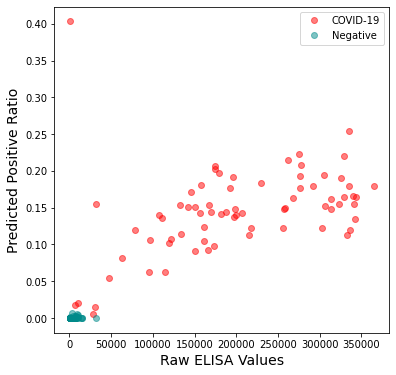

In [13]:
# Show correlation plots
c_spearman_mean, c_spearman_std, data_correlations = evaluate.evaluate_elisa(path_tmp/"ratios_{}/".format(protein), path_data_auxiliary/file_elisa, protein, antibody, dilution_antibody)
print("\nSpearman correlation mean={}, std={}".format(c_spearman_mean, c_spearman_std))

print("Example scatterplot:")
plotting.plot_correlation(data_correlations, protein, antibody)

### Comparison to Visual Ground Truth

Loading visual ground truth data from data_auxiliary/visual_gt.csv
Loading per-well predictions and comparing against visual ground truth
Calculating ROC curve and AUC (area under the curve)

Receiver Operating Characteristic (ROC) curve:
Area Under the Curve (AUC): 0.9814814814814815


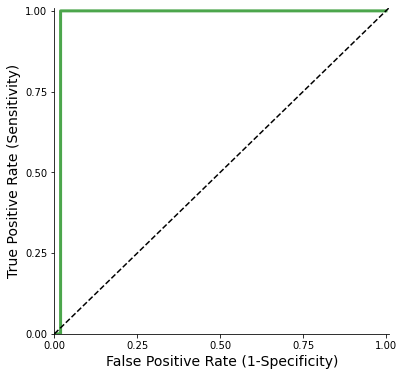

In [14]:
auc, df_scores = evaluate.evaluate_visual_gt(path_tmp/"ratios_{}/".format(protein), path_data_auxiliary/file_visual_gt, protein, antibody, dilution_antibody)

print("\nReceiver Operating Characteristic (ROC) curve:")
print("Area Under the Curve (AUC): {}".format(auc))
plotting.plot_ROC_curve(df_scores)